<a href="https://colab.research.google.com/github/dkaratzas/XNAP_Profs/blob/main/W05_01_Intro_to_CNN_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [ ]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data

Before training we need data! For this notebook we will use the FashionMNIST dataset. Which is available in [torchvision](https://pytorch.org/vision/stable/index.html)


In [ ]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False, num_workers=2)

## Convolutional model

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5) # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv#torch.nn.Conv2d
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature, 50)
        self.fc2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, self.n_feature)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Exercise 1

The model defined above has a mismatch shape problem. Calculate the correct input dimension for `fc1` and change its definition in the `__init__()` method and the call to `x.view()` in the forward pass.



In [ ]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5) # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv#torch.nn.Conv2d
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, self.n_feature * 4 *4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
torch.backends.cudnn.benchmark = True
learning_rate = 1e-2
lambda_l2 = 1e-5
momentum = 0.5
torch.manual_seed(0) # seed for reproductibility

output_size = 10  # there are 10 classes

model = CNN(6, output_size)

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2) # built-in L2

Number of parameters 6422:


# Exercise 2

- What does `torch.backends.cudnn.benchmark = True` do? 
- How will it affect our runtime if the size of the input images vary a lot?

It enables benchmark mode in cudnn. Benchmark mode is good whenever your input sizes for your network do not vary. This way, cudnn will look for the optimal set of algorithms for that particular configuration (which takes some time). This usually leads to faster runtime.
But if your input sizes changes at each iteration, then cudnn will benchmark every time a new size appears, possibly leading to worse runtime performances.

In [ ]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader, perm=torch.arange(0, 784).long()):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader, perm=torch.arange(0, 784).long()):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

# Exercise 3

Given the following convolutional layer:

`nn.Convd2(in_channels=3, out_channels=128, kernel_size=3)`

- What is the shape of the convolutional filter and its bias vector?
- What do the different feature maps encodes?

Filter: 128, 3, 3, 3 Bias: 128

Each feature map encodes a different representation of the input image/feature map, during the training process each kernel's filter will adjust its weights to encode each representation in a way that it is helpful for the task.

### Run Training

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306039
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.298027
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.219906

Test set: Average loss: 0.0042, Accuracy: 3575/10000 (36%)



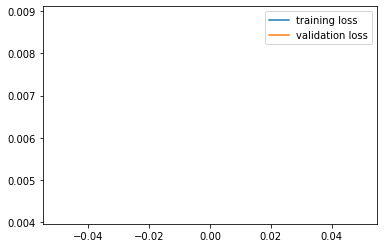

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.105615
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.010890
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.830596

Test set: Average loss: 0.0018, Accuracy: 6213/10000 (62%)



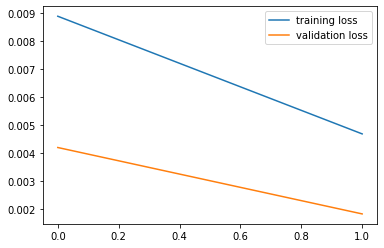

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.840576
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.866431
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.712985

Test set: Average loss: 0.0016, Accuracy: 6859/10000 (69%)



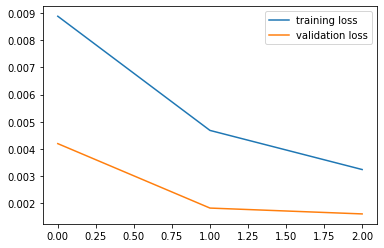

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.726519
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.882397
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.764140

Test set: Average loss: 0.0014, Accuracy: 7269/10000 (73%)



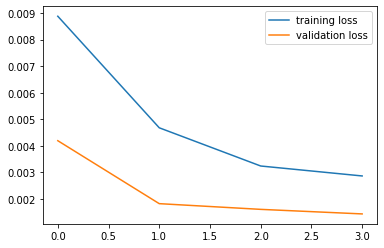

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.702228
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.673131
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.656677

Test set: Average loss: 0.0015, Accuracy: 7185/10000 (72%)



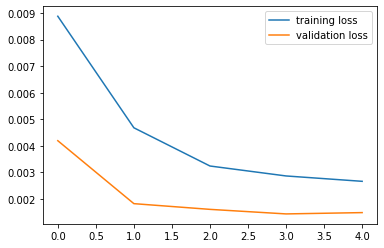

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.676590
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.615776
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.648197

Test set: Average loss: 0.0014, Accuracy: 7378/10000 (74%)



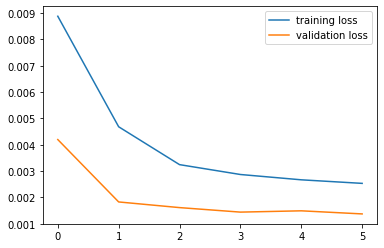

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.612647
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.644053
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.638951

Test set: Average loss: 0.0012, Accuracy: 7717/10000 (77%)



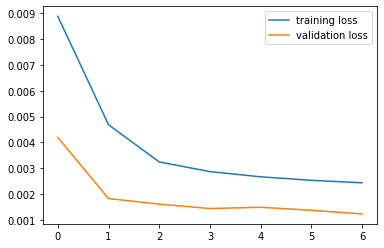

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.502882
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.563831
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.599796

Test set: Average loss: 0.0013, Accuracy: 7452/10000 (75%)



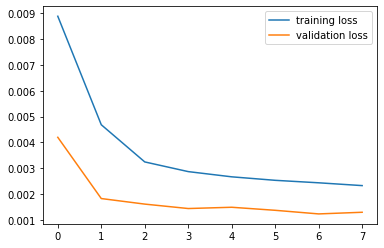

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.677981
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.555619
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.465737

Test set: Average loss: 0.0012, Accuracy: 7834/10000 (78%)



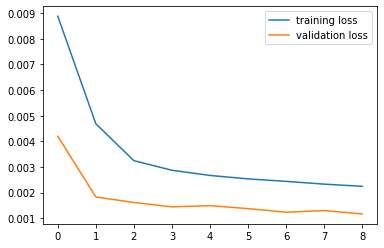

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.502742
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.548698
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.486473

Test set: Average loss: 0.0012, Accuracy: 7917/10000 (79%)



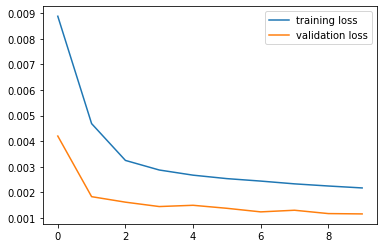

In [ ]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

# Homework

A) Train the same model but with all of the pixels in each image permuted (permute all images in the same way), is the performance worse? If not why?

B) With a trained model. Make prediction on 10 images, then, horizontally flip the same images and predict again. Is the performance the same? Why?

C) Visualize the feature maps of the first and last convolutional layers. What conclusions can you draw?

In [ ]:
# In order to extract feature maps we will use forward hooks https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=hook#torch.nn.Module.register_forward_hook
data, targets = next(iter(val_loader))

data, targets = data[:10].to(device), targets[:10].to(device)

output_conv1 = []
output_conv2 = []

hooks = [model.conv1.register_forward_hook(lambda self, input, output: output_conv1.append(output)),
         model.conv2.register_forward_hook(lambda self, input, output: output_conv2.append(output))]


model(data)

print(len(output_conv1)) # output conv is a list with the feature maps
print(output_conv1[0].shape)
for hook in hooks:
    hook.remove()

2
torch.Size([10, 128, 24, 24])


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306749
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.299633
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.293431

Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10%)



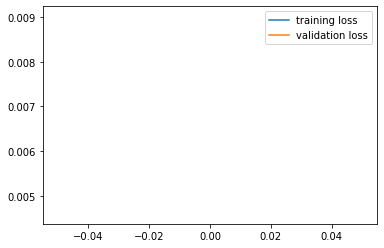

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296207
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.293398
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.284039

Test set: Average loss: 0.0046, Accuracy: 2828/10000 (28%)



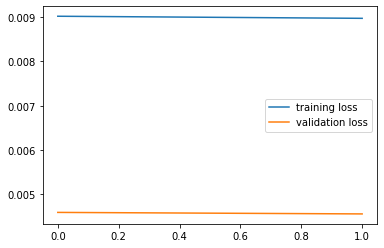

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.280342
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.262514
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.219235

Test set: Average loss: 0.0044, Accuracy: 2628/10000 (26%)



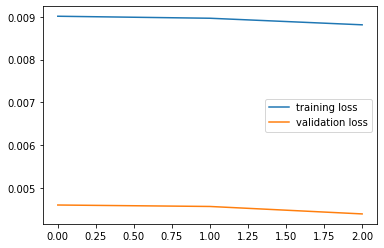

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.180117
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.990157
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.784162

Test set: Average loss: 0.0034, Accuracy: 4238/10000 (42%)



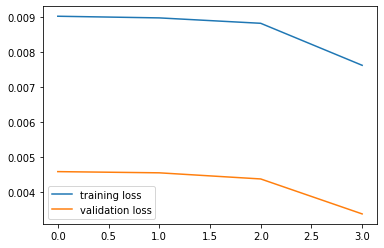

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.721660
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.402452
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.185664

Test set: Average loss: 0.0023, Accuracy: 5863/10000 (59%)



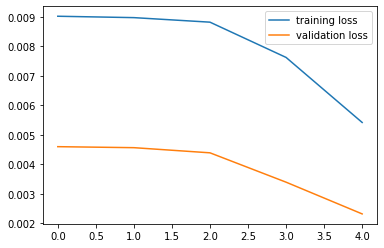

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.219693
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.146376
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.933260

Test set: Average loss: 0.0019, Accuracy: 6513/10000 (65%)



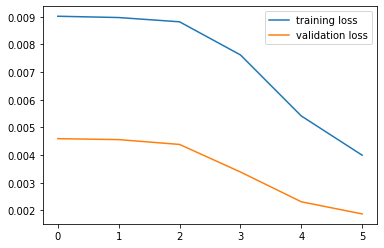

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.919831
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.795628
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.734294

Test set: Average loss: 0.0018, Accuracy: 6692/10000 (67%)



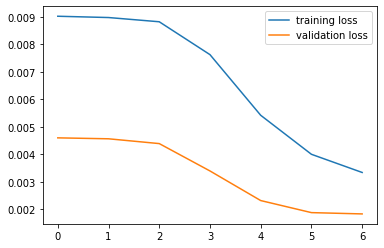

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.951569
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.774734
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.764610

Test set: Average loss: 0.0016, Accuracy: 7227/10000 (72%)



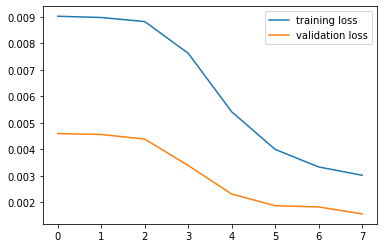

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.841254
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.827773
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.722999

Test set: Average loss: 0.0014, Accuracy: 7370/10000 (74%)



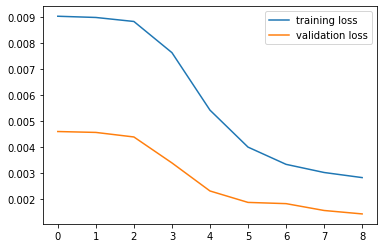

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.743575
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.661303
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.675377

Test set: Average loss: 0.0014, Accuracy: 7506/10000 (75%)



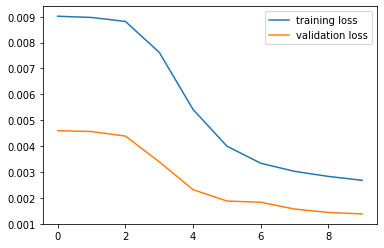

In [ ]:
#A)
model = CNN(6, output_size)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2) # built-in L2

perm = torch.randperm(784)
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader, perm=perm)
    val_loss = validate(criterion, model, val_loader, perm=perm)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

In [ ]:
# B)
model = CNN(6, output_size)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2) # built-in L2

for epoch in range(10):
    train(epoch, criterion, model, optimizer, train_loader)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=False, num_workers=0)

data, target = next(iter(val_loader))
data, target = data.to(device), target.to(device)

output = model(data)
pred = output.max(1)[1]
print("Correctly predicted: ", pred.eq(target.view_as(pred)).sum().item())

data = data.cpu().numpy()[..., ::-1].copy()
output = model(torch.from_numpy(data).to(device))
pred = output.max(1)[1]
print("Correctly predicted: ", pred.eq(target.view_as(pred)).sum().item())

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302841
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.298712
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.279996
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.269264
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.063046
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.260542
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.307482
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.889736
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.797421
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.949230
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.776474
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.710026
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.731991
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.714178
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.719634
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.932941
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.710965
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.697164
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.641200
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.739878
Train Epoch: 6 [51200/60000 (85%)]	

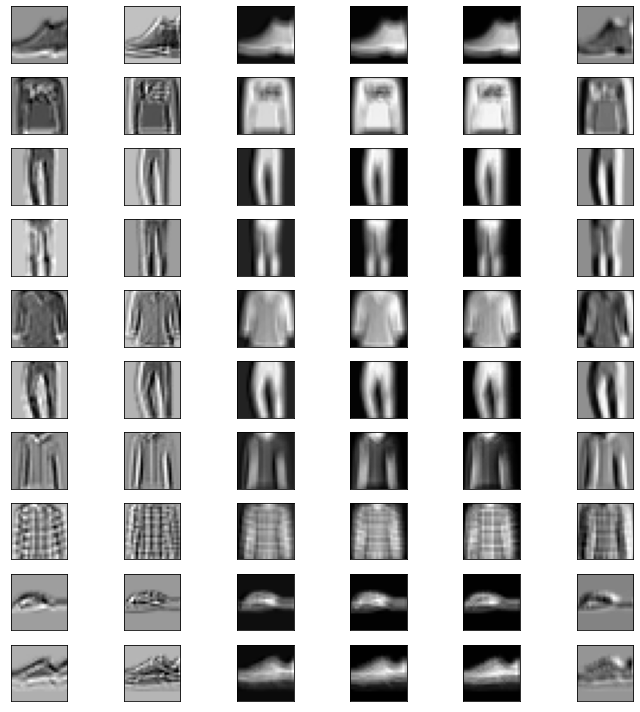

In [ ]:
# C)

def imshow(img, ax):
    
    out = img.data.numpy()
    out = out - out.min()
    out = out / out.max()
    out = out * 255
    out = out.astype('uint8')
    ax.axes.get_xaxis().set_visible(False)        
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(out, cmap='gray')

def show_conv_map(conv_map, shape):
    
    h = shape[0]
    w = shape[1]
    fig, ax = plt.subplots(h, w, figsize=(10, 10))

    # Show every channel's feature map
    for i in range(conv_map.shape[0]):
        for j in range(conv_map.shape[1]):
            imshow(conv_map[i][j], ax[i, j])
    
    fig.tight_layout()

data, targets = next(iter(val_loader))

data, targets = data[:10].to(device), targets[:10].to(device)

output_conv1 = []
output_conv2 = []

hooks = [model.conv1.register_forward_hook(lambda self, input, output: output_conv1.append(output)),
         model.conv2.register_forward_hook(lambda self, input, output: output_conv2.append(output))]

model(data)

show_conv_map(output_conv1[0].cpu(), shape=(10, 6))

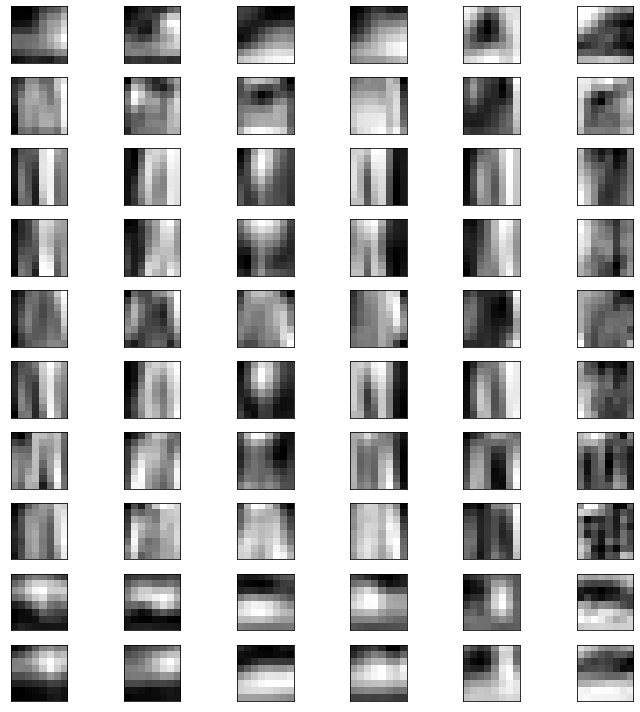

In [ ]:
show_conv_map(output_conv2[0].cpu(), shape=(10, 6))

It seems that the first layer is focusing on detecting corners and curves of objects, the last one (second one) is more abstract and it's harder to tell whats focusing on. It seems that it detects blobs in certain positions to figure out where the object is placed in the image.